In [272]:
! pip install pandas==0.25

     |████████████████████████████████| 10.5MB 4.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.25.0 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.25.0 which is incompatible.
  Found existing installation: pandas 1.1.4
    Uninstalling pandas-1.1.4:
      Successfully uninstalled pandas-1.1.4


In [1]:
import pkg_resources
pkg_resources.require("Pandas==0.25") # for panads_profiling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wn

%matplotlib inline
wn.filterwarnings('ignore')

In [2]:
pd.__version__

'0.25.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competições/Modeling Earthquake Damage/train_values.csv')
val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competições/Modeling Earthquake Damage/test_values.csv')
train_labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competições/Modeling Earthquake Damage/train_labels.csv')

In [5]:
train = train.merge(train_labels)

In [6]:
train.shape, val.shape

((260601, 40), (86868, 39))

In [7]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [8]:
train = train.drop(['building_id'], axis=1)

# EDA

## Report

In [9]:
from pandas_profiling import ProfileReport

report = ProfileReport(train)

In [10]:
report

Number of variables,39
Number of observations,260601
Total Missing (%),0.0%
Total size in memory,79.5 MiB
Average record size in memory,320.0 B
Numeric,9
Categorical,8
Boolean,22
Date,0
Text (Unique),0
Rejected,0


## Imbalance


In [104]:
numeric = train.select_dtypes('number')

In [105]:
binary = numeric.drop(['geo_level_1_id',
                      'geo_level_2_id',
                      'geo_level_3_id',
                      'count_floors_pre_eq',
                      'age',
                      'area_percentage',
                      'height_percentage',
                      'count_families',
                      'damage_grade'], axis=1)

In [106]:
# check imbalance
# has_superstructure_mud_mortar_stone
# has_superstructure_timber
# has_secondary_use
labels = binary.columns.tolist()
for label in labels:
  print(label,'     ',binary[label].value_counts().tolist()[1]/binary[label].value_counts().tolist()[0])

has_superstructure_adobe_mud       0.09726736842105263
has_superstructure_mud_mortar_stone       0.312448063819179
has_superstructure_stone_flag       0.03555278278906753
has_superstructure_cement_mortar_stone       0.018573455436605185
has_superstructure_mud_mortar_brick       0.0731386921429748
has_superstructure_cement_mortar_brick       0.08139476982065348
has_superstructure_timber       0.3422593754345844
has_superstructure_bamboo       0.09290953545232274
has_superstructure_rc_non_engineered       0.044484613349792784
has_superstructure_rc_engineered       0.016115070886036465
has_superstructure_other       0.015212547137470004
has_secondary_use       0.12597377346669836
has_secondary_use_agriculture       0.068807828597677
has_secondary_use_hotel       0.03479617849569962
has_secondary_use_rental       0.008166660218963983
has_secondary_use_institution       0.0009410192198374533
has_secondary_use_school       0.00036083483361291636
has_secondary_use_industry       0.00107174960

In [107]:
nominal = train.select_dtypes('object')

In [108]:
# check imbalance
# land_surface_condition
# roof_type
# ground_floor_type
# other_floor_type
labels = nominal.columns.tolist()
for label in labels:
  print(label,'     ',nominal[label].value_counts().tolist()[1]/nominal[label].value_counts().tolist()[0])

land_surface_condition       0.1639070479846095
foundation_type       0.06897023668315115
roof_type       0.33677163890134654
ground_floor_type       0.11867721914521108
other_floor_type       0.26287194007816944
position       0.21226186352615173
plan_configuration       0.02276144470392527
legal_ownership_status       0.021965497591048024


## Feature Engineering




### Feature Importance

In [109]:
X = train.drop(['damage_grade'], axis=1)
y = train['damage_grade']

In [110]:
cat_labels = X.select_dtypes('object').columns.tolist()

In [111]:
X = pd.get_dummies(X, columns=cat_labels)

In [112]:
X.shape, y.shape

((260601, 68), (260601,))

#### Wrapper Methods

##### Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [114]:
clf_rf = RandomForestClassifier(random_state=42).fit(X,y)

In [115]:
RF_features = pd.DataFrame(clf_rf.feature_importances_, index=X.columns.tolist(), 
                         columns=['RF']).sort_values(by=['RF'], ascending=False).head(30).index.tolist()

In [116]:
RF_features

['geo_level_3_id',
 'geo_level_2_id',
 'geo_level_1_id',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families',
 'count_floors_pre_eq',
 'foundation_type_r',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_timber',
 'ground_floor_type_v',
 'land_surface_condition_t',
 'has_superstructure_cement_mortar_brick',
 'ground_floor_type_f',
 'land_surface_condition_n',
 'position_s',
 'has_superstructure_adobe_mud',
 'other_floor_type_q',
 'roof_type_n',
 'has_secondary_use',
 'position_t',
 'roof_type_q',
 'has_superstructure_bamboo',
 'foundation_type_i',
 'has_superstructure_mud_mortar_brick',
 'other_floor_type_x',
 'ground_floor_type_x',
 'has_superstructure_stone_flag',
 'roof_type_x']

##### Extra Tree

In [117]:
from sklearn.tree import ExtraTreeClassifier

In [118]:
clf_et = ExtraTreeClassifier().fit(X,y)

In [119]:
ET_features = pd.DataFrame(clf_et.feature_importances_, index=X.columns.tolist(), 
                         columns=['ET']).sort_values(by=['ET'], ascending=False).head(30).index.tolist()

In [120]:
ET_features

['age',
 'area_percentage',
 'geo_level_3_id',
 'geo_level_1_id',
 'geo_level_2_id',
 'height_percentage',
 'count_families',
 'foundation_type_i',
 'count_floors_pre_eq',
 'has_superstructure_timber',
 'has_superstructure_mud_mortar_stone',
 'foundation_type_r',
 'has_superstructure_adobe_mud',
 'roof_type_n',
 'has_superstructure_mud_mortar_brick',
 'land_surface_condition_t',
 'has_superstructure_bamboo',
 'ground_floor_type_f',
 'foundation_type_u',
 'position_t',
 'roof_type_q',
 'other_floor_type_q',
 'has_superstructure_stone_flag',
 'land_surface_condition_n',
 'ground_floor_type_x',
 'other_floor_type_x',
 'position_s',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_other']

##### Select Predictors

In [121]:
wrapper_features = []
for el in RF_features:
  if el in ET_features:
    wrapper_features.append(el)

In [122]:
print(len(wrapper_features))
wrapper_features

27


['geo_level_3_id',
 'geo_level_2_id',
 'geo_level_1_id',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families',
 'count_floors_pre_eq',
 'foundation_type_r',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_timber',
 'land_surface_condition_t',
 'has_superstructure_cement_mortar_brick',
 'ground_floor_type_f',
 'land_surface_condition_n',
 'position_s',
 'has_superstructure_adobe_mud',
 'other_floor_type_q',
 'roof_type_n',
 'position_t',
 'roof_type_q',
 'has_superstructure_bamboo',
 'foundation_type_i',
 'has_superstructure_mud_mortar_brick',
 'other_floor_type_x',
 'ground_floor_type_x',
 'has_superstructure_stone_flag']

#### Filter Methods

In [123]:
filter = train.copy()
filter = pd.get_dummies(filter, columns=cat_labels)

In [124]:
train.shape, filter.shape

((260601, 39), (260601, 69))

##### Quantitative





In [125]:
quantitative = filter[['geo_level_1_id',
                      'geo_level_2_id',
                      'geo_level_3_id',
                      'count_floors_pre_eq',
                      'age',
                      'area_percentage',
                      'height_percentage',
                      'count_families',
                      'damage_grade']]

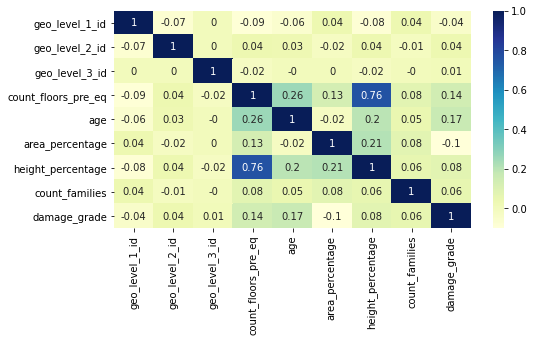

In [126]:
# spearm correlation heatmap
fig, ax=plt.subplots(figsize=(8,4))
sns.heatmap(quantitative.select_dtypes('number').corr(method='spearman').round(2), annot=True, cmap='YlGnBu', ax=ax);

In [127]:
from scipy.stats import spearmanr

###### count_floors_pre_eq ; height_percentage

In [128]:
spearmanr(train['count_floors_pre_eq'], train['height_percentage']) # high correlation

SpearmanrResult(correlation=0.7554792083087991, pvalue=0.0)

In [129]:
spearmanr(train['count_floors_pre_eq'], train['damage_grade']) # use count_floors_pre_eq

SpearmanrResult(correlation=0.14169833217151567, pvalue=0.0)

In [130]:
spearmanr(train['height_percentage'], train['damage_grade']) 

SpearmanrResult(correlation=0.08028182614939544, pvalue=0.0)

###### Association

In [131]:
quantitative_labels = quantitative.columns.tolist()
quantitative_labels.remove('height_percentage')
quantitative_labels.remove('damage_grade')

In [132]:
quantitative_association = []
for label in quantitative_labels:
  corr, _ = spearmanr(filter[label], filter['damage_grade'])
  if corr > 0.2:
    quantitative_association.append(label)

In [133]:
quantitative_association

[]

##### Nominal

In [134]:
from scipy.stats import chi2_contingency

In [135]:
def cramers_v(var1, var2):
  confusion_matrix = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum()
  phi2 = chi2 / n
  r, k = confusion_matrix.shape
  phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  rcorr = r - ((r-1)**2)/(n-1)
  kcorr = k - ((k-1)**2)/(n-1)
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [136]:
quantitative_labels = quantitative.columns.tolist()
binary_labels = filter.drop(quantitative_labels, axis=1).columns.tolist()

In [137]:
binary_corr = []
for i in range(len(binary_labels)):
  for j in range(len(binary_labels)):
    try:
      assert binary_labels[i] != binary_labels[j]
      binary_corr.append([binary_labels[i], 
                       binary_labels[j], 
                       cramers_v(filter[binary_labels[i]], filter[binary_labels[j]])]
                      )
    except:
      pass

In [138]:
binary_association = pd.DataFrame(binary_corr, columns=['label1','label2','Cramer_V'])\
                                  .drop_duplicates(subset=['Cramer_V'])\
                                  .sort_values(by=['Cramer_V'], ascending=False)

###### Strong association

In [139]:
label1 = binary_association.query('Cramer_V>=0.7')['label1'].tolist()
label2 = binary_association.query('Cramer_V>=0.7')['label2'].tolist()

strong_association = []
caution = []
for el1,el2 in zip(label1,label2):
  val1 = cramers_v(filter[el1], filter['damage_grade'])
  val2 = cramers_v(filter[el2], filter['damage_grade'])
  if val1 > 0.2:
    caution.append(el1)
  elif val2 > 0.2:
    caution.append(el2) 
  if val1 > val2:
    strong_association.append(el1)
  else:
    strong_association.append(el2)

strong_association = list(set(strong_association))
caution = list(set(caution))

In [140]:
strong_association

['roof_type_n',
 'land_surface_condition_t',
 'position_t',
 'roof_type_x',
 'plan_configuration_d',
 'legal_ownership_status_a',
 'has_secondary_use']

In [141]:
caution

['roof_type_x', 'foundation_type_i']

In [142]:
for el in caution:
  if el not in strong_association:
    strong_association.append(el)

In [143]:
strong_association

['roof_type_n',
 'land_surface_condition_t',
 'position_t',
 'roof_type_x',
 'plan_configuration_d',
 'legal_ownership_status_a',
 'has_secondary_use',
 'foundation_type_i']

###### Moderate association

In [144]:
label1 = binary_association.query('0.3<=Cramer_V<0.7')['label1'].tolist()
label2 = binary_association.query('0.3<=Cramer_V<0.7')['label2'].tolist()

moderate_association = []
caution = []
for el1,el2 in zip(label1,label2):
  val1 = cramers_v(filter[el1], filter['damage_grade'])
  val2 = cramers_v(filter[el2], filter['damage_grade'])
  if val1 > 0.2: 
    caution.append(el1)
  elif val2 > 0.3:
    caution.append(el2)
  if val1 > val2:
    moderate_association.append(el1)
  else:
    moderate_association.append(el2)

moderate_association = list(set(moderate_association))
caution = list(set(caution))

In [145]:
moderate_association

['foundation_type_r',
 'ground_floor_type_v',
 'other_floor_type_q',
 'foundation_type_w',
 'legal_ownership_status_v',
 'has_superstructure_adobe_mud',
 'land_surface_condition_t',
 'has_secondary_use_hotel',
 'foundation_type_i',
 'position_j',
 'other_floor_type_s',
 'has_superstructure_mud_mortar_stone',
 'roof_type_x',
 'plan_configuration_u',
 'has_superstructure_timber',
 'has_superstructure_cement_mortar_brick',
 'ground_floor_type_f']

In [146]:
caution

['foundation_type_r',
 'ground_floor_type_v',
 'has_superstructure_rc_engineered',
 'other_floor_type_q',
 'ground_floor_type_f',
 'foundation_type_i',
 'has_superstructure_mud_mortar_stone',
 'roof_type_x',
 'has_superstructure_cement_mortar_brick']

In [147]:
for el in caution:
  if el not in moderate_association:
    moderate_association.append(el)

In [148]:
moderate_association

['foundation_type_r',
 'ground_floor_type_v',
 'other_floor_type_q',
 'foundation_type_w',
 'legal_ownership_status_v',
 'has_superstructure_adobe_mud',
 'land_surface_condition_t',
 'has_secondary_use_hotel',
 'foundation_type_i',
 'position_j',
 'other_floor_type_s',
 'has_superstructure_mud_mortar_stone',
 'roof_type_x',
 'plan_configuration_u',
 'has_superstructure_timber',
 'has_superstructure_cement_mortar_brick',
 'ground_floor_type_f',
 'has_superstructure_rc_engineered']

###### Join

In [149]:
nominal_association = strong_association
for el in moderate_association:
  if el not in nominal_association:
    nominal_association.append(el)

In [150]:
nominal_association

['roof_type_n',
 'land_surface_condition_t',
 'position_t',
 'roof_type_x',
 'plan_configuration_d',
 'legal_ownership_status_a',
 'has_secondary_use',
 'foundation_type_i',
 'foundation_type_r',
 'ground_floor_type_v',
 'other_floor_type_q',
 'foundation_type_w',
 'legal_ownership_status_v',
 'has_superstructure_adobe_mud',
 'has_secondary_use_hotel',
 'position_j',
 'other_floor_type_s',
 'has_superstructure_mud_mortar_stone',
 'plan_configuration_u',
 'has_superstructure_timber',
 'has_superstructure_cement_mortar_brick',
 'ground_floor_type_f',
 'has_superstructure_rc_engineered']

##### Quantitative / Binary

In [151]:
from scipy.stats import pointbiserialr

In [152]:
biserial = []
for i in range(len(binary_labels)):
  for j in range(len(quantitative_labels)):
    value, _ = pointbiserialr(filter[binary_labels[i]], filter[quantitative_labels[j]])
    biserial.append(
                    [binary_labels[i], quantitative_labels[j], value]
                    )

In [153]:
biserial_association = pd.DataFrame(biserial, columns=['label1','label2','Point_Biserial'])\
                                    .drop_duplicates(subset=['Point_Biserial'])\
                                    .sort_values(by=['Point_Biserial'], ascending=False)

In [154]:
label1 = biserial_association.query('Point_Biserial<=-0.7 or Point_Biserial>=0.7')['label1'].tolist()
label2 = biserial_association.query('Point_Biserial<=-0.7 or Point_Biserial>=0.7')['label2'].tolist()

quantitative_binary_association = label1
for el in label2:
  if el not in quantitative_binary_association:
    quantitative_binary_association.append(el)

In [155]:
quantitative_binary_association

[]

##### Association with response variable

In [156]:
filter_features = quantitative_association

for el in nominal_association:
  if el not in filter_features:
    filter_features.append(el)

for el in quantitative_binary_association:
  if el not in filter_features:
    filter_features.append(el)

In [157]:
print(len(filter_features))
filter_features

23


['roof_type_n',
 'land_surface_condition_t',
 'position_t',
 'roof_type_x',
 'plan_configuration_d',
 'legal_ownership_status_a',
 'has_secondary_use',
 'foundation_type_i',
 'foundation_type_r',
 'ground_floor_type_v',
 'other_floor_type_q',
 'foundation_type_w',
 'legal_ownership_status_v',
 'has_superstructure_adobe_mud',
 'has_secondary_use_hotel',
 'position_j',
 'other_floor_type_s',
 'has_superstructure_mud_mortar_stone',
 'plan_configuration_u',
 'has_superstructure_timber',
 'has_superstructure_cement_mortar_brick',
 'ground_floor_type_f',
 'has_superstructure_rc_engineered']

### Select Predictors

wrapper_features\
filter_features

In [158]:
train_df = train.copy()
val_df = val.copy()

In [159]:
categorical_labels = train_df.select_dtypes('object').columns.tolist()

In [160]:
train_df = pd.get_dummies(train_df, columns = categorical_labels)
val_df = pd.get_dummies(val_df, columns=categorical_labels)

In [161]:
# predictors = wrapper_features

# for el in filter_features:
#   if el not in predictors:
#     predictors.append(el)

In [162]:
wrapper_features.append('damage_grade')

In [163]:
train_df = train_df[wrapper_features]

In [164]:
wrapper_features.remove('damage_grade')

In [165]:
val_df = val_df[wrapper_features]

### Feature Transformation

In [166]:
train_df.head(3)

,geo_level_3_id,geo_level_2_id,geo_level_1_id,age,area_percentage,height_percentage,count_families,count_floors_pre_eq,foundation_type_r,has_superstructure_mud_mortar_stone,has_superstructure_timber,land_surface_condition_t,has_superstructure_cement_mortar_brick,ground_floor_type_f,land_surface_condition_n,position_s,has_superstructure_adobe_mud,other_floor_type_q,roof_type_n,position_t,roof_type_q,has_superstructure_bamboo,foundation_type_i,has_superstructure_mud_mortar_brick,other_floor_type_x,ground_floor_type_x,has_superstructure_stone_flag,damage_grade
0,12198,487,6,30,6,5,1,2,1,1,0,1,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,3
1,2812,900,8,10,8,7,1,2,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,2
2,8973,363,21,10,5,5,1,2,1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,3


#### geo_level_1_id

In [167]:
from sklearn.cluster import KMeans

In [168]:
geo1 = np.array(train_df['geo_level_1_id']).reshape(-1,1)
association = []
clusters = np.arange(2,11)
for c in clusters:
  kmeans = KMeans(n_clusters=c, random_state=42).fit(geo1)
  ass, _ = spearmanr(train_df['damage_grade'], kmeans.labels_) 
  association.append([c,ass])

association # 3 or 5 clusters

[[2, -0.012919720573425855],
 [3, 0.1675160166885989],
 [4, -0.06638476450494157],
 [5, -0.166109182139388],
 [6, 0.08985218587150919],
 [7, 0.02818666042759728],
 [8, 9.114089694292648e-05],
 [9, 0.022999168980235903],
 [10, 0.026354635626087784]]

In [169]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(geo1)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 46549, 132347,  81705]))

In [170]:
train_df['geo1_kmeans'] = kmeans.labels_

In [171]:
geo1_validation = np.array(val_df['geo_level_1_id']).reshape(-1,1)
kmeans = KMeans(n_clusters=3, random_state=42).fit(geo1_validation)

In [172]:
val_df['geo1_kmeans'] = geo1_validation

# Model

In [173]:
X = train_df.drop(['damage_grade'], axis=1)
y = train_df[['damage_grade']]

In [174]:
X.shape, y.shape

((260601, 28), (260601, 1))

### Split


In [175]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [176]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((182420, 28), (78181, 28), (182420, 1), (78181, 1))

### LightGBM [[1]](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

#### Model

In [177]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
num_leaves = [10, 30, 50]
max_depth = [5, 10, 30, 50]
learning_rate = [0.5, 0.8, 1, 1.5]
n_estimators = [50, 100, 150]
subsample = [0.5, 0.8, 1]
min_child_samples = [10, 50, 100]
min_child_weight = [0.001, 0.01, 0.1, 1]
reg_alpha = [0, 0.1, 1, 5]
reg_lambda = [0, 0.1, 1, 5]

param_distributions = dict(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                           subsample=subsample, min_child_samples=min_child_samples, min_child_weight=min_child_weight,
                           reg_alpha=reg_alpha, reg_lambda=reg_lambda)

clf = LGBMClassifier(objective='multiclass', random_state=42, n_jobs=-1)

search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, 
                            cv=3, scoring='accuracy', refit=True, verbose=True, random_state=42).fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


In [ ]:
search.best_params_

{'learning_rate': 0.5,
 'max_depth': 50,
 'min_child_samples': 10,
 'min_child_weight': 0.001,
 'n_estimators': 100,
 'num_leaves': 50,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.5}

In [178]:
lgbm = LGBMClassifier(objective='multiclass', random_state=42, 
                     learning_rate= 0.5,
                    max_depth= 5,
                    min_child_samples= 10,
                    min_child_weight= 0.01,
                    n_estimators= 150,
                    num_leaves= 50,
                    reg_alpha= 5,
                    reg_lambda= 1,
                    subsample= 1)

In [179]:
lgbm.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=5,
               min_child_samples=10, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=150, n_jobs=-1, num_leaves=50,
               objective='multiclass', random_state=42, reg_alpha=5,
               reg_lambda=1, silent=True, subsample=1, subsample_for_bin=200000,
               subsample_freq=0)

In [180]:
y_pred = lgbm.predict(x_test)

#### Evaluation

In [181]:
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [182]:
confusion_matrix(y_test, y_pred, labels=[1,2,3])

array([[ 3664,  3851,    86],
       [ 1496, 37744,  5174],
       [  119, 10176, 15871]])

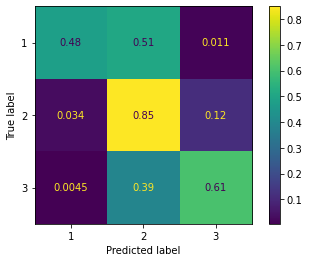

In [183]:
plot_confusion_matrix(lgbm, x_test, y_test, normalize='true');

In [184]:
f1_score(y_test, y_pred, average='micro')

0.7326460393190163

In [185]:
cross_val_score(lgbm, x_train, y_train, cv=3).mean()

0.72652670581328

- RF_features -> accuracy: 0.7350379248154921
- predictors -> accuracy: 0.7295762397513461
- filter_features -> accuracy: 0.5850782159348179

#### Explaination with SHAP

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(lgbm)

In [ ]:
shap_values = explainer.shap_values(x_test.iloc[:1000,:])

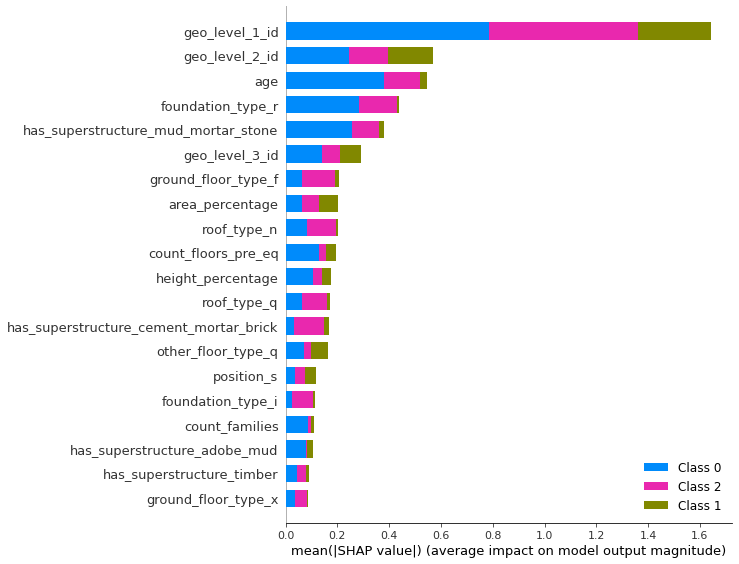

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, x_test.iloc[:1000,:])

SHAP calculates the probabilities on the log-odds space: $log(p) = log\frac{p}{(1-p)}$\
The features in pink increase the log-odds probability, whereas the features in blue decrease it, in the proportion of each feature bar length.\
The first two predictions are shown ahead:



In [ ]:
# show first prediction
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], x_test.iloc[0,:])

In [ ]:
# show second prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_test.iloc[0,:])

### XGBoost [[1]](https://machinelearningmastery.com/stochastic-gradient-boosting-xgboost-scikit-learn-python/), [[2]](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/), [[3]](https://github.com/ernestng11/touchpoint-prediction/blob/master/model-building.ipynb), [[4]](https://xgboost.readthedocs.io/en/latest/python/python_api.html)



In [ ]:
import xgboost
from xgboost.sklearn import XGBClassifier

In [ ]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000, 
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=3,
                    seed=42)

In [ ]:
xgb.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric = ['merror','mlogloss'],
        early_stopping_rounds=500,
        verbose=True)

[0]	validation_0-merror:0.344781	validation_0-mlogloss:1.05329	validation_1-merror:0.346504	validation_1-mlogloss:1.05359
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 500 rounds.
[1]	validation_0-merror:0.344266	validation_0-mlogloss:1.01815	validation_1-merror:0.346721	validation_1-mlogloss:1.01866
[2]	validation_0-merror:0.344326	validation_0-mlogloss:0.983838	validation_1-merror:0.346504	validation_1-mlogloss:0.984374
[3]	validation_0-merror:0.343997	validation_0-mlogloss:0.958109	validation_1-merror:0.346401	validation_1-mlogloss:0.958783
[4]	validation_0-merror:0.342813	validation_0-mlogloss:0.931321	validation_1-merror:0.34525	validation_1-mlogloss:0.932097
[5]	validation_0-merror:0.343115	validation_0-mlogloss:0.908253	validation_1-merror:0.345199	validation_1-mlogloss:0.909047
[6]	validation_0-merror:0.341931	validation_0-mlogloss:0.887254	validation_1-merror:0.344534	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=0.8, verbosity=1)

In [ ]:
y_pred = xgb.predict(x_test)

In [ ]:
# get results
results = xgb.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(epochs)

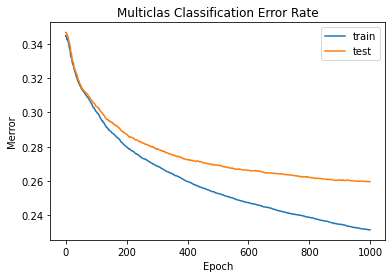

In [ ]:
# plot merror
plt.plot(x_axis, results['validation_0']['merror'], label='train')
plt.plot(x_axis, results['validation_1']['merror'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Merror')
plt.title('Multiclas Classification Error Rate')
plt.legend();

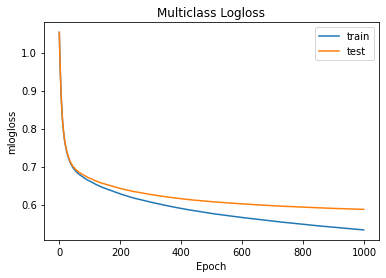

In [ ]:
# plot mlogloss
plt.plot(x_axis, results['validation_0']['mlogloss'], label='train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('mlogloss')
plt.title('Multiclass Logloss')
plt.legend();

In [ ]:
confusion_matrix(y_test, y_pred, labels=[1,2,3])

array([[ 3792,  3720,    89],
       [ 1453, 37987,  4974],
       [  127,  9942, 16097]])

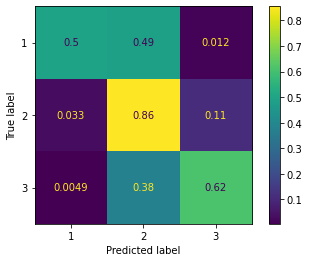

In [ ]:
plot_confusion_matrix(xgb, x_test, y_test, normalize='true');

In [ ]:
f1_score(y_test, y_pred, average='micro')

0.740282165743595

In [ ]:
cross_val_score(xgb, x_train, y_train, cv=3).mean()

0.7366133128732432

f1_score: 0.74\
cross_val_score: 0.7366

#### Explaination with SHAP

In [209]:
import shap

In [267]:
explainer = shap.TreeExplainer(xgb)

In [268]:
shap_values = explainer.shap_values(x_test.iloc[:1000,:])

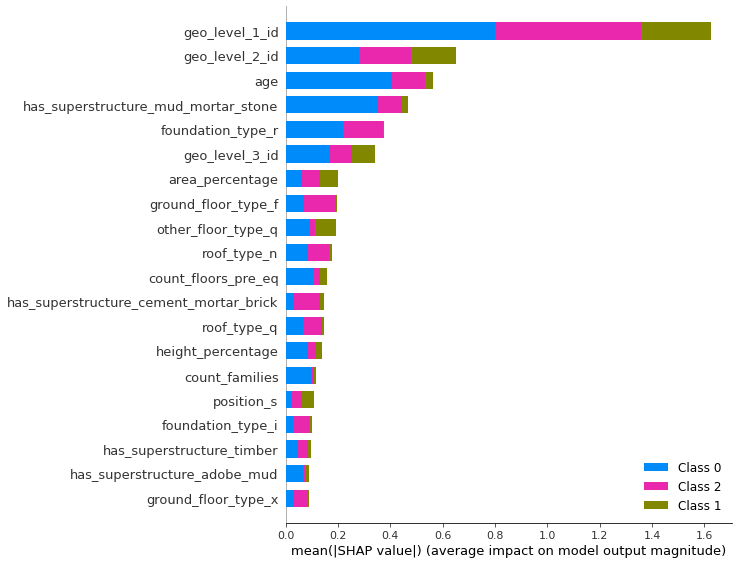

In [269]:
shap.initjs()
shap.summary_plot(shap_values, x_test.iloc[:1000,:])

SHAP calculates the probabilities on the log-odds space: $log(p) = log\frac{p}{(1-p)}$\
The features in pink increase the log-odds probability, whereas the features in blue decrease it, in the proportion of each feature bar length.\
The first two predictions are shown ahead:



In [270]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], x_test.iloc[0,:])

In [271]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_test.iloc[0,:])

# Submission

In [259]:
val_df.shape

(86868, 28)

In [262]:
ids = val['building_id']

In [263]:
pred_submission = xgb.predict(val_df)

In [264]:
submission = pd.DataFrame(pred_submission, index=ids, columns=['damage_grade'])

In [265]:
submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [266]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/Competições/Modeling Earthquake Damage/submission.csv')

# Save and Load Model

In [11]:
import pickle

In [ ]:
# save the model
pickle.dump(xgb, open('xgboost_model.sv','wb'))

In [ ]:
# load the model
load_xgb = pickle.load(open('xgboost_model.sv','rb'))